In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import *     # Import all the preprocessing methods
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, balanced_accuracy_score, accuracy_score, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import numpy as np
import sys, pickle, itertools
from sklearn.model_selection import train_test_split, TimeSeriesSplit
plt.rcParams["figure.figsize"] = (10,7)

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
train_set = pd.read_csv('./data/train_df_expanded_KNN_imp_7kfeats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

In [3]:
y_train = train_set['Target > 2']
x_train = train_set.drop(['Date', 'window_start', 'window_duration', 'within_window', 'Target', 'Abs Target', 'Target > 2'], axis=1)

In [2]:
#Keep best X features
with open("./metadata/top_K_feat_from_7k.pkl", "rb") as f:
    top_k_feats = pickle.load(f)

# x_train = x_train[list(top_k_feats)]

In [5]:
if 'psi' in list(top_k_feats):
    print('a')

In [3]:
top_k_feats

{'Avg_CCS1_DH6325Ps_psi_diff1',
 'Avg_CCS1_DH6325Ps_psi_pct_change1',
 'Avg_CCS1_DH6325Ps_psi_pct_change4',
 'Avg_CCS1_WHCO2InjPs_psi',
 'Avg_CCS1_WHCO2InjPs_psi ema 5',
 'Avg_CCS1_WHCO2InjPs_psi_diff1',
 'Avg_CCS1_WHCO2InjPs_psi_diff2',
 'Avg_CCS1_WHCO2InjPs_psi_pct_change1',
 'Avg_CCS1_WHCO2InjTp_F_diff1',
 'Avg_PLT_CO2VentRate_TPH MACD_12_26_9',
 'Avg_PLT_CO2VentRate_TPH_diff1',
 'Avg_PLT_CO2VentRate_TPH_pct_change1',
 'Log abs Avg_PLT_CO2VentRate_TPH MACD_Histogram_12_26_9',
 'Pressure diff 6945-5482 ft_pct_change1',
 'Pressure diff 6945-6720 ft_pct_change2',
 'Temperature diff 5653-5001 ft sma 5',
 'Temperature diff 6837-6720 ft ema 10'}

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

X_test = X_test.iloc[26:]
y_test = y_test.iloc[26:]

In [10]:
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_test, y_test)

In [21]:
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'eval_metric': ['logloss'],
    'tree_method': ['exact'],
    'nthread': [-2],
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1, np.sqrt(sum(y_train==0)/sum(y_train==1))]
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [22]:
# Initialize empty lists to store results
auc_scores = []
aucpr_scores = []
best_thresholds = []
confusion_matrices = []
hyparparams_list = []
num_trees_list = []

for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    clf = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=250,verbose_eval=False,early_stopping_rounds=5)

    # Make predictions on the test set
    y_pred_train = clf.predict(dtrain)
    y_pred_val = clf.predict(dval)

    num_trees = clf.best_ntree_limit
    num_trees_list.append(num_trees)

    # Calculate the precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_val)
    
    # Calculate AUC and AUCPR
    print(f'AUC={auc(recall, precision)}')
    print(f'AUCPR={average_precision_score(y_test, y_pred_val)}')
    auc_scores.append(auc(recall, precision))
    aucpr_scores.append(average_precision_score(y_test, y_pred_val))

    # Find the best threshold
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_threshold)

    # Calculate TP, FP, FN using the best threshold
    y_pred = (y_pred_val > best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    confusion_matrices.append((tp, fp, fn))
    print(f'TP={tp}, FP={fp}, FN={fn}')

    print('--'*5)

# Combine the results into a list of dictionaries
results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    results.append({
        'hyperparameters': hyperparams,
        'AUC': auc_scores[i],
        'AUCPR': aucpr_scores[i],
        'Best_threshold': best_thresholds[i],
        'TP': confusion_matrices[i][0],
        'FP': confusion_matrices[i][1],
        'FN': confusion_matrices[i][2],
    })

AUC=0.9687745194347173
AUCPR=0.9688661123626308
TP=173, FP=14, FN=15
----------
AUC=0.949536358382093
AUCPR=0.9499497399538572
TP=171, FP=22, FN=17
----------
AUC=0.9681148721579047
AUCPR=0.9682290988106206
TP=169, FP=11, FN=19
----------
AUC=0.9686279941974313
AUCPR=0.9687393043868229
TP=173, FP=10, FN=15
----------
AUC=0.9558740771285473
AUCPR=0.9560460482205732
TP=171, FP=17, FN=17
----------
AUC=0.9546216765495859
AUCPR=0.9548426323409597
TP=179, FP=23, FN=9
----------
AUC=0.9665242635938183
AUCPR=0.9666613503983837
TP=172, FP=11, FN=16
----------
AUC=0.9685179813860262
AUCPR=0.9685987902727581
TP=173, FP=13, FN=15
----------
AUC=0.967313610987407
AUCPR=0.9674262318408343
TP=168, FP=15, FN=20
----------
AUC=0.9706173631630055
AUCPR=0.9707035915670146
TP=177, FP=21, FN=11
----------
AUC=0.9674281983940911
AUCPR=0.9675591358875664
TP=178, FP=17, FN=10
----------
AUC=0.9734352397604294
AUCPR=0.9735099667329934
TP=172, FP=10, FN=16
----------
AUC=0.961462984423783
AUCPR=0.9615898545336

In [23]:
np.argmax([x['AUCPR'] for x in results])

11

In [26]:
num_trees_list[11]

43

In [25]:
results[26]

{'hyperparameters': {'alpha': 1,
  'lambda': 5,
  'colsample_bytree': 1,
  'colsample_bylevel': 0.7,
  'subsample': 1,
  'eval_metric': 'logloss',
  'tree_method': 'exact',
  'nthread': -2,
  'objective': 'binary:logistic',
  'scale_pos_weight': 1},
 'AUC': 0.972685676226667,
 'AUCPR': 0.972769247720651,
 'Best_threshold': 0.49884367,
 'TP': 173,
 'FP': 10,
 'FN': 15}

### Get best result

In [13]:
y_pred_train = clf.predict(dtrain)
y_pred_val = clf.predict(dval)

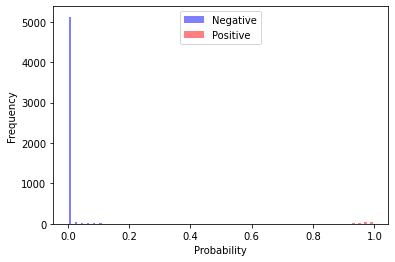

In [14]:
# plot the histogram of probabilities with the color representing the true label
plt.hist([y_pred_val[y_test==0], y_pred_val[y_test==1]], bins=50, color=['b', 'r'], alpha=0.5, label=['Negative', 'Positive'])
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper center')
plt.show()

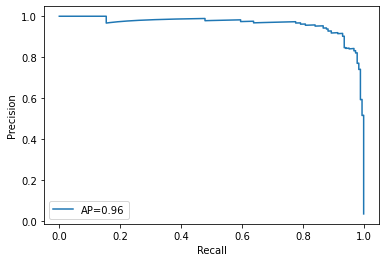

In [15]:
# calculate and plot the AUC-PR curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_val)
average_precision = average_precision_score(y_test, y_pred_val)
plt.plot(recall, precision, label='AP={:.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [16]:
# calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_val)
area = auc(recall, precision)

# find the threshold that maximizes the AUC-PR
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

# print the best threshold and the corresponding AUC-PR
print('Best Threshold: {:.4f}'.format(best_threshold))

Best Threshold: 0.3725


## Old confusion-matrix
All feat:
TP=269
FN=38
FP=23

Top 4 feat:
TP=273
FN=34
FP=23

In [18]:
# predict binary labels using the best threshold
y_pred = (y_pred_val >= best_threshold).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [19]:
cm

array([[5258,   16],
       [  13,  175]], dtype=int64)

In [40]:
cm

array([[8722,   33],
       [  34,  273]], dtype=int64)

## NOT USED

In [ ]:
int(np.ceil(optimal_num_trees))

In [16]:
feature_list = list(x_train.columns)
best_features = ['Avg_PLT_CO2VentRate_TPH_diff1']
train_aucs = []
train_aucs_std = []
val_aucs = []
val_aucs_std = []
test_aucs = []
train_logloss = []
train_logloss_std = []
val_logloss = []
val_logloss_std = []
test_logloss = []

while len(feature_list)>1:

    for feature in feature_list:

        feature_dict = {}

        temp_train = x_train[best_features+[feature]]
        dtrain = xgb.DMatrix(temp_train, y_train)

        # CROSS VALIDATION
        
        xgb_cv = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,  # Maximum iterations
        nfold=4, # Number of folds to use
        metrics=['auc','logloss'], # List of evaluation metrics to be used in cross validation, when it is not specified, the evaluation metric is chosen according to objective function.
        as_pandas=False,
        seed=42,
        stratified=True,
        early_stopping_rounds=10, # Training with a validation set will stop if the performance doesn't improve for n rounds.
        )

        loglosses_train = np.round(xgb_cv['train-logloss-mean'][-1],4)
        loglosses_train_std = np.round(xgb_cv['train-logloss-std'][-1],4)
        loglosses_val = np.round(xgb_cv['test-logloss-mean'][-1],4)
        loglosses_val_std = np.round(xgb_cv['test-logloss-std'][-1],4)
        auc_train = np.round(xgb_cv['train-auc-mean'][-1],4)
        auc_train_std = np.round(xgb_cv['train-auc-std'][-1],4)
        auc_val = np.round(xgb_cv['test-auc-mean'][-1],4)
        auc_val_std = np.round(xgb_cv['test-auc-std'][-1],4)
                
        feature_dict[feature] = [loglosses_val, loglosses_val_std, loglosses_train, loglosses_train_std,
                                auc_val, auc_val_std, auc_train, auc_train_std]

        
        best_feature = min((feature_dict[key][0],key) for key in feature_dict)[1]

    # TEST

    temp_test = x_test[best_features+[feature]]
    dtest = xgb.DMatrix(temp_test, y_test)

    clf = xgb.XGBClassifier(**params)
    clf.set_params(n_estimators=len(xgb_cv['test-auc-std'])+int(np.log(len(xgb_cv['test-auc-std'])))+2)
    clf = clf.fit(x_train[best_features+[feature]], y_train)
    # pred = clf.predict_proba(x_test)[:,1]

    # fpr, tpr, thresholds = roc_curve(y_test, pred)
    # test_auc = auc(fpr, tpr)
    pred = clf.predict(temp_test)
    test_auc = accuracy_score(y_test, pred)
    test_log = log_loss(y_test, clf.predict_proba(temp_test), labels=[0, 1])


    print('\n')
    print('*****'*5)
    best_features.append(best_feature)
    print(f'Best features so far: {best_features} \n Train mean logloss: {feature_dict[best_feature][2]:.4f} +/- {feature_dict[best_feature][3]:.4f}  \n Val mean logloss: {feature_dict[best_feature][0]:.4f} +/- {feature_dict[best_feature][1]:.4f}')
    print(f' Train mean auc: {feature_dict[best_feature][6]:.4f} +/- {feature_dict[best_feature][7]:.4f}  \n Val mean auc: {feature_dict[best_feature][4]:.4f} +/- {feature_dict[best_feature][5]:.4f}')
    print(f'Test auc: {test_auc:.4f}')
    print(len(best_features))
    print(len(feature_list))

    train_aucs.append(feature_dict[best_feature][6])
    train_aucs_std.append(feature_dict[best_feature][7])
    val_aucs.append(feature_dict[best_feature][4])
    val_aucs_std.append(feature_dict[best_feature][5])
    test_aucs.append(test_auc)

    train_logloss.append(feature_dict[best_feature][2])
    train_logloss_std.append(feature_dict[best_feature][3])
    val_logloss.append(feature_dict[best_feature][0])
    val_logloss_std.append(feature_dict[best_feature][1])
    test_logloss.append(test_log)


    # Remove best feature from list of features
    feature_list.remove(best_feature)



*************************
Best features so far: ['is_blending'] 
 Train mean logloss: 0.6016 +/- 0.0049  
 Val mean logloss: 0.6088 +/- 0.0116
 Train mean auc: 0.5457 +/- 0.0238  
 Val mean auc: 0.5466 +/- 0.0717
Test auc: 1.0000
1
79


*************************
Best features so far: ['is_blending', 'SpinGap'] 
 Train mean logloss: 0.5510 +/- 0.0112  
 Val mean logloss: 0.5739 +/- 0.0256
 Train mean auc: 0.7145 +/- 0.0319  
 Val mean auc: 0.6647 +/- 0.1022
Test auc: 1.0000
2
78


*************************
Best features so far: ['is_blending', 'SpinGap', 'N2_FI_std'] 
 Train mean logloss: 0.4595 +/- 0.0185  
 Val mean logloss: 0.5475 +/- 0.0375
 Train mean auc: 0.8673 +/- 0.0154  
 Val mean auc: 0.7242 +/- 0.0648
Test auc: 1.0000
3
77


*************************
Best features so far: ['is_blending', 'SpinGap', 'N2_FI_std', 'N2_FI_ave'] 
 Train mean logloss: 0.3585 +/- 0.0164  
 Val mean logloss: 0.4962 +/- 0.0415
 Train mean auc: 0.9462 +/- 0.0065  
 Val mean auc: 0.7849 +/- 0.0632
Te

In [22]:
x = [i for i in range(len(train_aucs_std))]

In [23]:
plt.rcParams["figure.figsize"] = (12,8)

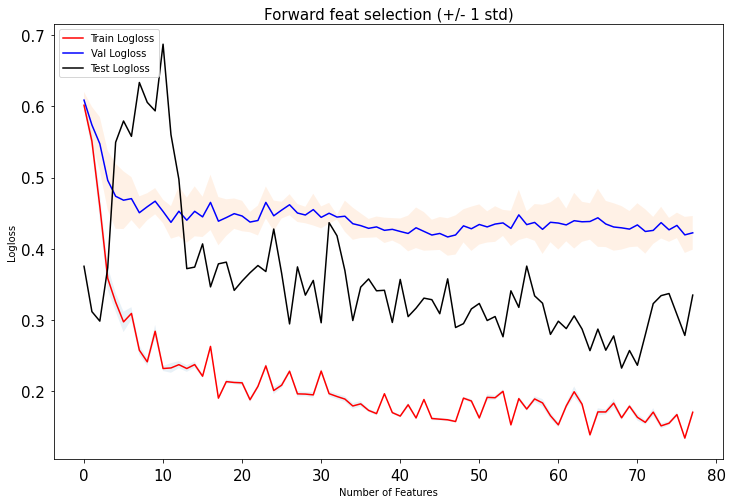

In [24]:
plt.plot(x, train_logloss, 'r', label='Train Logloss')
plt.fill_between(x, np.array(train_logloss)-np.array(train_logloss_std), np.array(train_logloss)+np.array(train_logloss_std), alpha=.1)
plt.plot(x, val_logloss, 'b', label='Val Logloss')
plt.fill_between(x, np.array(val_logloss)-np.array(val_logloss_std), np.array(val_logloss)+np.array(val_logloss_std), alpha=.1)
plt.plot(x, test_logloss, 'k', label='Test Logloss')
plt.xlabel('Number of Features')
plt.ylabel('Logloss')
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.title('Forward feat selection (+/- 1 std)', fontsize=15)
plt.legend(loc='upper left');

In [27]:
val_logloss[np.argmin(val_logloss)]

0.4167

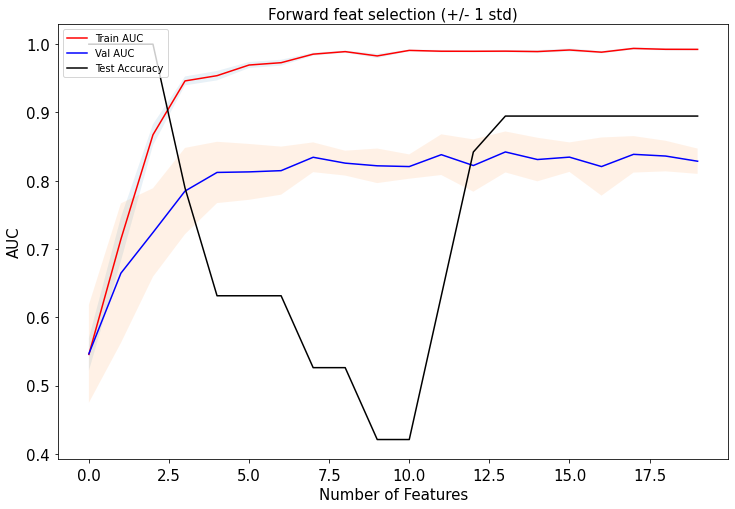

In [35]:
plt.plot(x[:20], train_aucs[:20], 'r', label='Train AUC')
plt.fill_between(x[:20], np.array(train_aucs[:20])-np.array(train_aucs_std[:20]), np.array(train_aucs[:20])+np.array(train_aucs_std[:20]), alpha=.1)
plt.plot(x[:20], val_aucs[:20], 'b', label='Val AUC')
plt.fill_between(x[:20], np.array(val_aucs[:20])-np.array(val_aucs_std[:20]), np.array(val_aucs[:20])+np.array(val_aucs_std[:20]), alpha=.1)
plt.xlabel('Number of Features', fontsize=15)
plt.plot(x[:20], test_aucs[:20], 'k', label='Test Accuracy')
plt.ylabel('AUC', fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.title('Forward feat selection (+/- 1 std)', fontsize=15)
plt.legend(loc='upper left');

In [29]:
val_aucs[np.argmax(val_aucs)]

0.8597

In [30]:
np.argmax(val_aucs)

45

In [34]:
feat = best_features[:np.argmax(val_aucs)]

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

xgb_cv = xgb.cv(
  params=params,
  dtrain=dtrain,
  num_boost_round=1000,  # Maximum iterations
  nfold=4, # Number of folds to use
  metrics=['auc','logloss'], # List of evaluation metrics to be used in cross validation, when it is not specified, the evaluation metric is chosen according to objective function.
  as_pandas=True,
  seed=41,
  stratified=True,
  early_stopping_rounds=10, # Training with a validation set will stop if the performance doesn't improve for n rounds.
)

xgb_cv

,train-auc-mean,train-auc-std,train-logloss-mean,train-logloss-std,test-auc-mean,test-auc-std,test-logloss-mean,test-logloss-std
0,0.835403,0.041317,0.670746,0.001551,0.724488,0.047550,0.676034,0.001915
1,0.899189,0.029542,0.649445,0.002909,0.773181,0.044666,0.661422,0.003503
2,0.935126,0.014960,0.631832,0.004322,0.783098,0.066852,0.649962,0.005821
3,0.952386,0.009281,0.614010,0.003323,0.767877,0.055257,0.640722,0.007511
4,0.961504,0.015102,0.597163,0.004452,0.785689,0.062876,0.629870,0.008974
...,...,...,...,...,...,...,...,...
117,0.999934,0.000081,0.148954,0.007743,0.855214,0.061223,0.418612,0.061879
118,0.999934,0.000081,0.147965,0.007630,0.854045,0.061411,0.418546,0.061524
119,0.999934,0.000081,0.146935,0.007344,0.853752,0.061459,0.418148,0.061224
120,0.999934,0.000081,0.145836,0.007245,0.853135,0.060759,0.418108,0.061759
